In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
class Config:
    LOG_DIR = '~/.dosdetect/logs'
    MODEL_DIR = '~/.dosdetect/models'

    @classmethod
    def set_log_dir(cls, log_dir):
        cls.LOG_DIR = log_dir or cls.LOG_DIR

    @classmethod
    def set_model_dir(cls, model_dir):
        cls.MODEL_DIR = model_dir or cls.MODEL_DIR

In [3]:
import logging
import os

def setup_logger(name, log_file, level=logging.INFO):
    """
    Set up a logger with the specified name, log file, log directory, and logging level.

    Args:
        name (str): The name of the logger.
        log_file (str): The name of the log file.
        level (int, optional): The logging level. Defaults to logging.INFO.

    Returns:
        logging.Logger: The configured logger instance.
    """
    logger = logging.getLogger(name)
    logger.setLevel(level)

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    # Expand the user's home directory if necessary, safe to use for all paths
    expanded_log_dir = os.path.expanduser(Config.LOG_DIR)
    try:
        os.makedirs(expanded_log_dir, exist_ok=True)
    except Exception as e:
        print(f"Error creating directories: {e}")  # Catch and print any error

    log_path = os.path.join(expanded_log_dir, log_file)

    file_handler = logging.FileHandler(log_path)
    file_handler.setFormatter(formatter)

    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)

    return logger

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

import logging

logger = setup_logger('data_loader_logger', 'data_loader.log', level=logging.DEBUG)


class DataLoader:
    """
    A class for loading and splitting data from CSV files.
    """

    def __init__(self, file_paths):
        """
        Initialize the DataLoader with file paths.

        Args:
            file_paths (list): List of file paths to CSV files.
        """
        self.file_paths = file_paths
        logger.debug(f"DataLoader initialized with file paths: {file_paths}")

    def load_data(self):
        """
        Load data from CSV files and concatenate them into a single DataFrame.

        Returns:
            pandas.DataFrame: Concatenated DataFrame containing all the loaded data.
        """
        logger.info("Loading data from CSV files...")
        data_frames = []

        # Iterate over each file path
        for file_path in self.file_paths:
            # Read CSV file into a DataFrame
            df = pd.read_csv(file_path)
            data_frames.append(df)
            logger.debug(f"Loaded data from {file_path}. Shape: {df.shape}")

        # Concatenate all DataFrames into a single DataFrame
        all_data = pd.concat(data_frames, ignore_index=True)
        logger.info(f"All data loaded and concatenated. Shape: {all_data.shape}")

        return all_data

    def split_data(self, X, y, train_size=0.6, val_size=0.2, test_size=0.2):
        """
        Split the data into train, validation, and test sets.

        Args:
            X (pandas.DataFrame): Input features.
            y (pandas.Series): Target labels.
            train_size (float): Proportion of data to include in the train set.
            val_size (float): Proportion of data to include in the validation set.
            test_size (float): Proportion of data to include in the test set.

        Returns:
            tuple: A tuple containing the split data:
                - (X_train, y_train): Train set features and labels.
                - (X_val, y_val): Validation set features and labels.
                - (X_test, y_test): Test set features and labels.
        """
        logger.info("Splitting data into train, validation, and test sets...")

        # Calculate the ratios for train and validation sets
        train_ratio = train_size / (train_size + val_size + test_size)
        val_ratio = val_size / (train_size + val_size + test_size)

        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio, random_state=42)
        logger.debug(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")

        # Split the test set further into validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size/(test_size+val_size), random_state=42)
        logger.debug(f"Validation set size: {len(X_val)}, Test set size: {len(X_test)}")

        logger.info("Data split completed.")

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
import re
import logging


logger = setup_logger('preprocessor_logger', 'preprocessor.log', level=logging.DEBUG)


class PreprocessorBuilder:
    """
    Builder class for constructing a Preprocessor instance with specified preprocessing steps.
    """

    def __init__(self):
        """
        Initialize the PreprocessorBuilder with an empty list of preprocessing steps.
        """
        self.steps = []
        logger.debug("PreprocessorBuilder initialized with empty steps.")
    
    def with_label_encoding(self):
        """
        Add label encoding step to the preprocessing pipeline.

        Returns:
            PreprocessorBuilder: The builder instance with the label encoding step added.
        """
        self.steps.append(LabelEncoder())
        logger.debug("Label encoding step added to PreprocessorBuilder.")
        return self
    
    def with_correlated_feature_removal(self, correlation_threshold=0.9):
        """
        Add correlated feature removal step to the preprocessing pipeline.

        Args:
            correlation_threshold (float, optional): The threshold for determining highly correlated features.
                Defaults to 0.9.

        Returns:
            PreprocessorBuilder: The builder instance with the correlated feature removal step added.
        """
        self.steps.append(CorrelatedFeatureRemover(correlation_threshold))
        logger.debug(f"Correlated feature removal step added to PreprocessorBuilder with threshold {correlation_threshold}.")
        return self
    
    def with_pca(self, pca_variance_ratio=0.95):
        """
        Add PCA transformation step to the preprocessing pipeline.

        Args:
            pca_variance_ratio (float, optional): The desired amount of variance to retain in the PCA transformation.
                Defaults to 0.95.

        Returns:
            PreprocessorBuilder: The builder instance with the PCA transformation step added.
        """
        self.steps.append(PCATransformer(pca_variance_ratio))
        logger.debug(f"PCA transformation step added to PreprocessorBuilder with variance ratio {pca_variance_ratio}.")
        return self
    
    def with_data_cleaning(self, fill_method='median'):
        """
        Add data cleaning step to the preprocessing pipeline.

        Args:
            fill_method (str, optional): The method for filling infinite and NaN values.
                Supported values: 'median', 'mean', or any other value. Defaults to 'median'.

        Returns:
            PreprocessorBuilder: The builder instance with the data cleaning step added.
        """
        self.steps.append(DataCleaner(fill_method))
        logger.debug(f"Data cleaning step added to PreprocessorBuilder with fill method '{fill_method}'.")
        return self
    
    def build(self):
        """
        Build and return the Preprocessor instance with the specified preprocessing steps.

        Returns:
            Preprocessor: The constructed Preprocessor instance.
        """
        preprocessor = Preprocessor(self.steps)
        logger.debug("Preprocessor instance built from PreprocessorBuilder.")
        return preprocessor


class Preprocessor:
    """
    Preprocessor class for applying a sequence of preprocessing steps to the data.
    """

    def __init__(self, steps):
        """
        Initialize the Preprocessor with the specified preprocessing steps.

        Args:
            steps (list): A list of preprocessing steps to be applied in sequence.
        """
        self.steps = steps
        logger.debug(f"Preprocessor initialized with {len(steps)} preprocessing steps.")
    
    def preprocess_data(self, X, y=None):
        """
        Preprocess the input data by applying the specified preprocessing steps.

        Args:
            X (pandas.DataFrame): The input features.
            y (pandas.Series, optional): The target labels. Defaults to None.

        Returns:
            tuple: A tuple containing the preprocessed features (X) and labels (y).
        """
        logger.info("Starting data preprocessing...")
        X = self.sanitize_column_names(X)
        
        for step in self.steps:
            if isinstance(step, LabelEncoder):
                logger.info("Applying label encoding...")
                y = self.encode_labels(y, step)
            elif isinstance(step, CorrelatedFeatureRemover):
                logger.info("Removing correlated features...")
                X = step.remove_correlated_features(X)
            elif isinstance(step, PCATransformer):
                logger.info("Applying PCA transformation...")
                X = step.apply_pca(X)
            elif isinstance(step, DataCleaner):
                logger.info("Cleaning data...")
                X = step.clean_data(X)
        
        logger.info("Data preprocessing completed.")
        return X, y
    
    def encode_labels(self, y, label_encoder):
        """
        Encode the target labels using the specified label encoder.

        Args:
            y (pandas.Series): The target labels.
            label_encoder (LabelEncoder): The label encoder instance.

        Returns:
            numpy.ndarray: The encoded labels in categorical format.
        """
        logger.debug("Encoding labels...")
        y_encoded = label_encoder.fit_transform(y)
        
        # Print the mapping of original labels to encoded values
        label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        logger.debug(f"Label Mapping: {label_mapping}")
        
        num_classes = len(label_encoder.classes_)
        y_categorical = to_categorical(y_encoded, num_classes=num_classes)
        
        logger.debug("Label encoding completed.")
        return y_categorical, label_mapping

    def sanitize_column_names(self, X):
        """
        Sanitize the column names of the input features.

        Args:
            X (pandas.DataFrame): The input features.

        Returns:
            pandas.DataFrame: The input features with sanitized column names.
        """
        logger.debug("Sanitizing column names...")
        
        # Modify column names in place:
        #   - Convert column names to lowercase
        #   - Replace non-alphanumeric characters with underscores
        #   - Strip leading and trailing whitespaces
        X.columns = X.columns.str.strip().str.replace(' ', '_').str.replace('-', '_').str.lower()
        
        logger.debug("Column names sanitized.")
        
        # Return the modified DataFrame
        return X

class CorrelatedFeatureRemover:
    """
    Class for removing highly correlated features from the dataset.
    """

    def __init__(self, correlation_threshold=0.9):
        """
        Initialize the CorrelatedFeatureRemover with the specified correlation threshold.

        Args:
            correlation_threshold (float, optional): The threshold for determining highly correlated features.
                Defaults to 0.9.
        """
        self.correlation_threshold = correlation_threshold
        logger.debug(f"CorrelatedFeatureRemover initialized with threshold {correlation_threshold}.")
    
    def remove_correlated_features(self, X):
        """
        Remove highly correlated features from the dataset.

        Args:
            X (pandas.DataFrame): The input features.

        Returns:
            pandas.DataFrame: The dataset with selected features after removing highly correlated ones.
        """
        logger.debug("Removing correlated features...")
        # Compute the correlation matrix
        correlation_matrix = X.corr()
        correlated_features = set()
        
        # Iterate over the upper triangle of the correlation matrix
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                if abs(correlation_matrix.iloc[i, j]) > self.correlation_threshold:
                    colname = correlation_matrix.columns[i]
                    correlated_features.add(colname)
        
        # Drop the correlated features from the dataset
        selected_features = X.columns.drop(correlated_features)
        X_selected = X[selected_features]
        
        logger.debug(f"Removed {len(correlated_features)} correlated features.")
        return X_selected


class PCATransformer:
    """
    Class for applying PCA transformation to the dataset.
    """

    def __init__(self, pca_variance_ratio=0.95):
        """
        Initialize the PCATransformer with the specified variance ratio.

        Args:
            pca_variance_ratio (float, optional): The desired amount of variance to retain in the PCA transformation.
                Defaults to 0.95.
        """
        self.pca_variance_ratio = pca_variance_ratio
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=pca_variance_ratio)
        logger.debug(f"PCATransformer initialized with variance ratio {pca_variance_ratio}.")
    
    def apply_pca(self, X):
        """
        Apply PCA transformation to the dataset.

        Args:
            X (pandas.DataFrame): The input features.

        Returns:
            numpy.ndarray: The transformed dataset after applying PCA.
        """
        logger.debug("Applying PCA transformation...")
        # Scale the data
        X_scaled = self.scaler.fit_transform(X)
        
        # Apply PCA transformation
        X_pca = self.pca.fit_transform(X_scaled)
        
        logger.debug(f"PCA transformation applied. Transformed dataset shape: {X_pca.shape}")
        return X_pca


class DataCleaner:
    """
    Class for cleaning the dataset by handling infinite and NaN values.
    """

    def __init__(self, fill_method='median'):
        """
        Initialize the DataCleaner with the specified fill method.

        Args:
            fill_method (str, optional): The method for filling infinite and NaN values.
                Supported values: 'median', 'mean', or any other value. Defaults to 'median'.
        """
        self.fill_method = fill_method
        logger.debug(f"DataCleaner initialized with fill method '{fill_method}'.")
    
    def clean_data(self, data):
        """
        Clean the dataset by handling infinite and NaN values.

        Args:
            data (pandas.DataFrame): The input dataset.

        Returns:
            pandas.DataFrame: The cleaned dataset with infinite and NaN values handled.
        """
        logger.debug("Cleaning data...")

        if not isinstance(data, pd.DataFrame):
            raise TypeError(f"Expected a pandas DataFrame, but got {type(data)} instead.")

        # Replace infinite values with NaN using pandas methods
        data.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Check and fill NaN values based on the selected fill method
        for column in data.columns:
            if data[column].isnull().any():  # Check if there are any NaN values in the column
                if self.fill_method == 'median':
                    fill_value = data[column].median()
                elif self.fill_method == 'mean':
                    fill_value = data[column].mean()
                elif self.fill_method == 'zero':
                    fill_value = 0
                else:
                    # Assuming self.fill_method is a callable that returns a scalar
                    # This path needs specific handling based on what self.fill_method is
                    fill_value = self.fill_method(data[column])

                # Assign the result of fillna directly to the DataFrame column
                data[column] = data[column].fillna(fill_value)

        logger.debug("Data cleaning completed.")
        return data

In [9]:
root_path = '/Users/seansica/OneDrive - Sica/Education/Berkeley/W207-Applied-ML/datasci-207-final-project/datasets/CICIDS2017/MachineLearningCVE'
    
file_paths = [
        f'{root_path}/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
        f'{root_path}/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
        f'{root_path}/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
        f'{root_path}/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
        f'{root_path}/Friday-WorkingHours-Morning.pcap_ISCX.csv',
        f'{root_path}/Tuesday-WorkingHours.pcap_ISCX.csv',
        f'{root_path}/Monday-WorkingHours.pcap_ISCX.csv',
        f'{root_path}/Wednesday-workingHours.pcap_ISCX.csv'
    ]

In [10]:
data_loader = DataLoader(file_paths)

all_data = data_loader.load_data()

X = all_data.drop(columns=[' Label'])
y = all_data[' Label']
logger.debug("Features (X) and labels (y) extracted from the loaded data.")

correlation_threshold=0.9
pca_variance_ratio=0.95
n_neighbors=5

preprocessor = PreprocessorBuilder() \
    .with_data_cleaning(fill_method='median') \
    .with_correlated_feature_removal(correlation_threshold=correlation_threshold) \
    .with_pca(pca_variance_ratio=pca_variance_ratio) \
    .with_label_encoding() \
    .build()

X_preprocessed, y_encoded_tuple = preprocessor.preprocess_data(X, y)
y_encoded = y_encoded_tuple[0]

(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_loader.split_data(X_preprocessed, y_encoded)

2024-04-02 21:27:43,699 - preprocessor_logger - DEBUG - DataLoader initialized with file paths: ['/Users/seansica/OneDrive - Sica/Education/Berkeley/W207-Applied-ML/datasci-207-final-project/datasets/CICIDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', '/Users/seansica/OneDrive - Sica/Education/Berkeley/W207-Applied-ML/datasci-207-final-project/datasets/CICIDS2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', '/Users/seansica/OneDrive - Sica/Education/Berkeley/W207-Applied-ML/datasci-207-final-project/datasets/CICIDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', '/Users/seansica/OneDrive - Sica/Education/Berkeley/W207-Applied-ML/datasci-207-final-project/datasets/CICIDS2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', '/Users/seansica/OneDrive - Sica/Education/Berkeley/W207-Applied-ML/datasci-207-final-project/datasets/CICIDS2017/MachineLearningCVE/Friday-Workin

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [12]:
from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.9942223690229958

In [28]:
display(y_pred[90:100])
display(y_test[90:100])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [20]:
from sklearn.metrics import accuracy_score

# Remove the first class from the predictions and ground truth
y_pred_excluding_first = y_pred[:, 1:]
y_test_excluding_first = y_test[:, 1:]

# Calculate the accuracy
accuracy_excluding_first = accuracy_score(y_test_excluding_first, y_pred_excluding_first)

print("Accuracy (excluding first class):", accuracy_excluding_first)


Accuracy (excluding first class): 0.9942400322176671


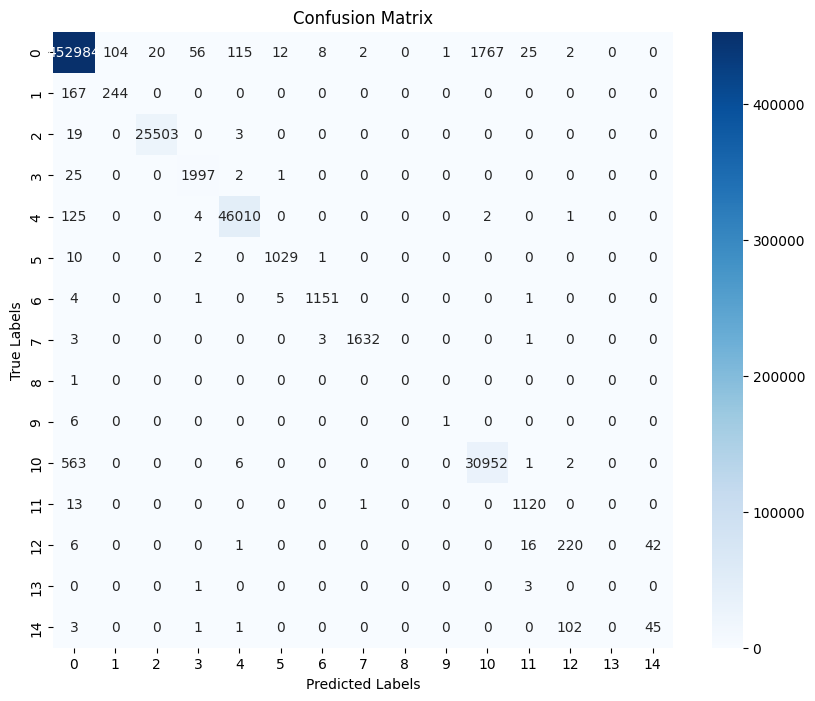

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

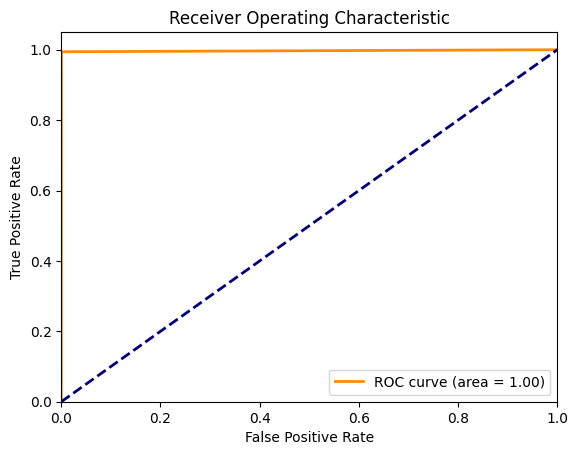

In [19]:
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [33]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout

input_shape = (X_train.shape[1], 1)
num_classes = y_encoded.shape[1]

bi_lstm_cnn = tf.keras.Sequential([
    # Convolutional layer
    Conv1D(64, 3, activation='relu', input_shape=input_shape),
    
    # Bidirectional LSTM layers
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    
    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [34]:
optimizer='adam'
loss='categorical_crossentropy'
metrics=['accuracy']

bi_lstm_cnn.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [35]:
epochs = 10
batch_size = 32
validation_data = (X_val, y_val)

bi_lstm_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

Epoch 1/10
 1077/53077 ━━━━━━━━━━━━━━━━━━━━ 56:04 65ms/step - accuracy: 0.8308 - loss: 0.6760

KeyboardInterrupt: 